In [1]:
# notebooks/01_eda_analysis.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the dataset - FIXED PATH with multiple fallback options
from pathlib import Path
import numpy as np

# Try multiple possible paths
POSSIBLE_PATHS = [
    Path("data/row/raw_analyst_ratings.csv"),
    Path("data/raw/raw_analyst_ratings.csv"),
    Path("../data/row/raw_analyst_ratings.csv"),
    Path("../data/raw/raw_analyst_ratings.csv"),
]

def resolve_data_path(possible_paths) -> Path:
    """Return the first existing path for the dataset searching up the tree."""
    cwd = Path.cwd().resolve()
    for relative_path in possible_paths:
        for base in [cwd, *cwd.parents]:
            candidate = base / relative_path
            if candidate.exists():
                return candidate
    return None

def create_sample_data():
    """Create sample news data for testing if the actual file is not found."""
    print("⚠️  Creating sample data for demonstration purposes...")
    print("   Please ensure you have the actual data file: data/row/raw_analyst_ratings.csv")
    
    np.random.seed(42)
    n_samples = 10000
    
    # Sample headlines
    headlines_templates = [
        "{stock} Stock Surges on Strong Earnings Report",
        "{stock} Shares Drop After CEO Resignation",
        "Analyst Upgrades {stock} to Buy Rating",
        "{stock} Announces Major Acquisition Deal",
        "{stock} Reports Record Quarterly Revenue",
        "Market Volatility Hits {stock} Stock Price",
        "{stock} Launches New Product Line",
        "Regulatory Concerns Weigh on {stock} Shares",
        "{stock} Beats Earnings Expectations",
        "{stock} Stock Split Announced",
    ]
    
    publishers = ["Reuters", "Bloomberg", "CNBC", "Financial Times", "Wall Street Journal", 
                  "MarketWatch", "Yahoo Finance", "Seeking Alpha", "Forbes", "Barron's"]
    
    stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "JPM", "V", "JNJ"]
    
    dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
    dates = dates[dates.dayofweek < 5]  # Business days only
    
    data = {
        'date': np.random.choice(dates, n_samples),
        'headline': [np.random.choice(headlines_templates).format(stock=np.random.choice(stocks)) 
                    for _ in range(n_samples)],
        'publisher': np.random.choice(publishers, n_samples),
        'stock': np.random.choice(stocks, n_samples),
    }
    
    df = pd.DataFrame(data)
    print(f"✓ Created sample dataset with {len(df)} rows")
    return df

def load_data():
    """Load data from file or create sample data as fallback."""
    # Try to find the actual data file
    data_path = resolve_data_path(POSSIBLE_PATHS)
    
    if data_path:
        try:
            news_df = pd.read_csv(data_path)
            print(f"✓ Loaded dataset from {data_path}")
            print(f"✓ Dataset loaded with {len(news_df)} rows and {len(news_df.columns)} columns")
            return news_df
        except Exception as e:
            print(f"⚠️  Error reading file {data_path}: {e}")
            print("   Falling back to sample data...")
            return create_sample_data()
    else:
        print("⚠️  Data file not found in any of the expected locations:")
        for path in POSSIBLE_PATHS:
            print(f"   - {path}")
        print("\n   Creating sample data for demonstration...")
        return create_sample_data()

# Load data
df = load_data()

# Basic info
print("\n=== Dataset Info ===")
print(df.info())

print("\n=== First 5 rows ===")
print(df.head())

print("\n=== Column names ===")
print(df.columns.tolist())

✓ Loaded dataset from C:\project\kifya\Week1\data\raw\raw_analyst_ratings.csv
✓ Dataset loaded with 1407328 rows and 6 columns

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None

=== First 5 rows ===
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-

In [3]:
# Fix the date parsing based on your actual data format
print("=== DEBUGGING DATA LOADING ===")
if df is not None and not df.empty:
    print(f"DataFrame shape: {df.shape}")
    print(f"DataFrame columns: {df.columns.tolist()}")
    print(f"First few rows of 'date' column:")
    print(df['date'].head(10))
    print(f"Data types: {df.dtypes}")
else:
    print("ERROR: DataFrame is None or empty. Please check data loading.")

# Now let's fix the date parsing and run complete analysis
def fixed_descriptive_stats(df):
    print("=== COMPLETE DESCRIPTIVE STATISTICS ===")
    
    # 1. Headline length analysis
    print("Step 1: Analyzing headline lengths...")
    df['headline_length'] = df['headline'].astype(str).apply(len)
    df['word_count'] = df['headline'].astype(str).apply(lambda x: len(str(x).split()))
    
    print(f"\n1. Headline Length Statistics:")
    print(f"   Average characters: {df['headline_length'].mean():.2f}")
    print(f"   Average words: {df['word_count'].mean():.2f}")
    print(f"   Max characters: {df['headline_length'].max()}")
    print(f"   Min characters: {df['headline_length'].min()}")
    
    # 2. Articles per publisher
    print("Step 2: Analyzing publishers...")
    publisher_counts = df['publisher'].value_counts()
    print(f"\n2. Top 10 Publishers by Article Count:")
    for i, (publisher, count) in enumerate(publisher_counts.head(10).items()):
        print(f"   {i+1}. {publisher}: {count} articles")
    
    # 3. Date analysis - FIXED PARSING
    print("Step 3: Analyzing dates...")
    
    # Handle different date formats (string or already datetime)
    if pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date_parsed'] = df['date']
    else:
        # Try multiple date formats
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
        # If that fails, try specific format
        if df['date_parsed'].isna().sum() > len(df) * 0.5:  # If more than 50% failed
            df['date_parsed'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    
    # Check for parsing errors
    nat_count = df['date_parsed'].isna().sum()
    if nat_count > 0:
        print(f"   Warning: {nat_count} dates could not be parsed")
        # Show samples that failed
        failed_dates = df[df['date_parsed'].isna()]['date'].head(5)
        print(f"   Sample failed dates: {list(failed_dates)}")
    
    print(f"   Date Range: {df['date_parsed'].min()} to {df['date_parsed'].max()}")
    print(f"   Total days covered: {(df['date_parsed'].max() - df['date_parsed'].min()).days} days")
    
    # 4. Stock coverage
    print("Step 4: Analyzing stock coverage...")
    stock_counts = df['stock'].value_counts()
    print(f"\n4. Top 10 Stocks by Coverage:")
    for i, (stock, count) in enumerate(stock_counts.head(10).items()):
        print(f"   {i+1}. {stock}: {count} articles")
    
    print("\n✅ Descriptive statistics completed successfully!")
    return df

# Run the fixed function
df = fixed_descriptive_stats(df)

=== DEBUGGING DATA LOADING ===
DataFrame shape: (1407328, 6)
DataFrame columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']
First few rows of 'date' column:
0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
5    2020-05-22 11:23:25-04:00
6    2020-05-22 09:36:20-04:00
7    2020-05-22 09:07:04-04:00
8    2020-05-22 08:37:59-04:00
9    2020-05-22 08:06:17-04:00
Name: date, dtype: object
Data types: Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object
=== COMPLETE DESCRIPTIVE STATISTICS ===
Step 1: Analyzing headline lengths...

1. Headline Length Statistics:
   Average characters: 73.12
   Average words: 11.42
   Max characters: 512
   Min characters: 3
Step 2: Analyzing publishers...

2. Top 10 Publishers by Article Count:
   1. Paul Quintaro: 228373 articles
   2. Lisa Levin: 1

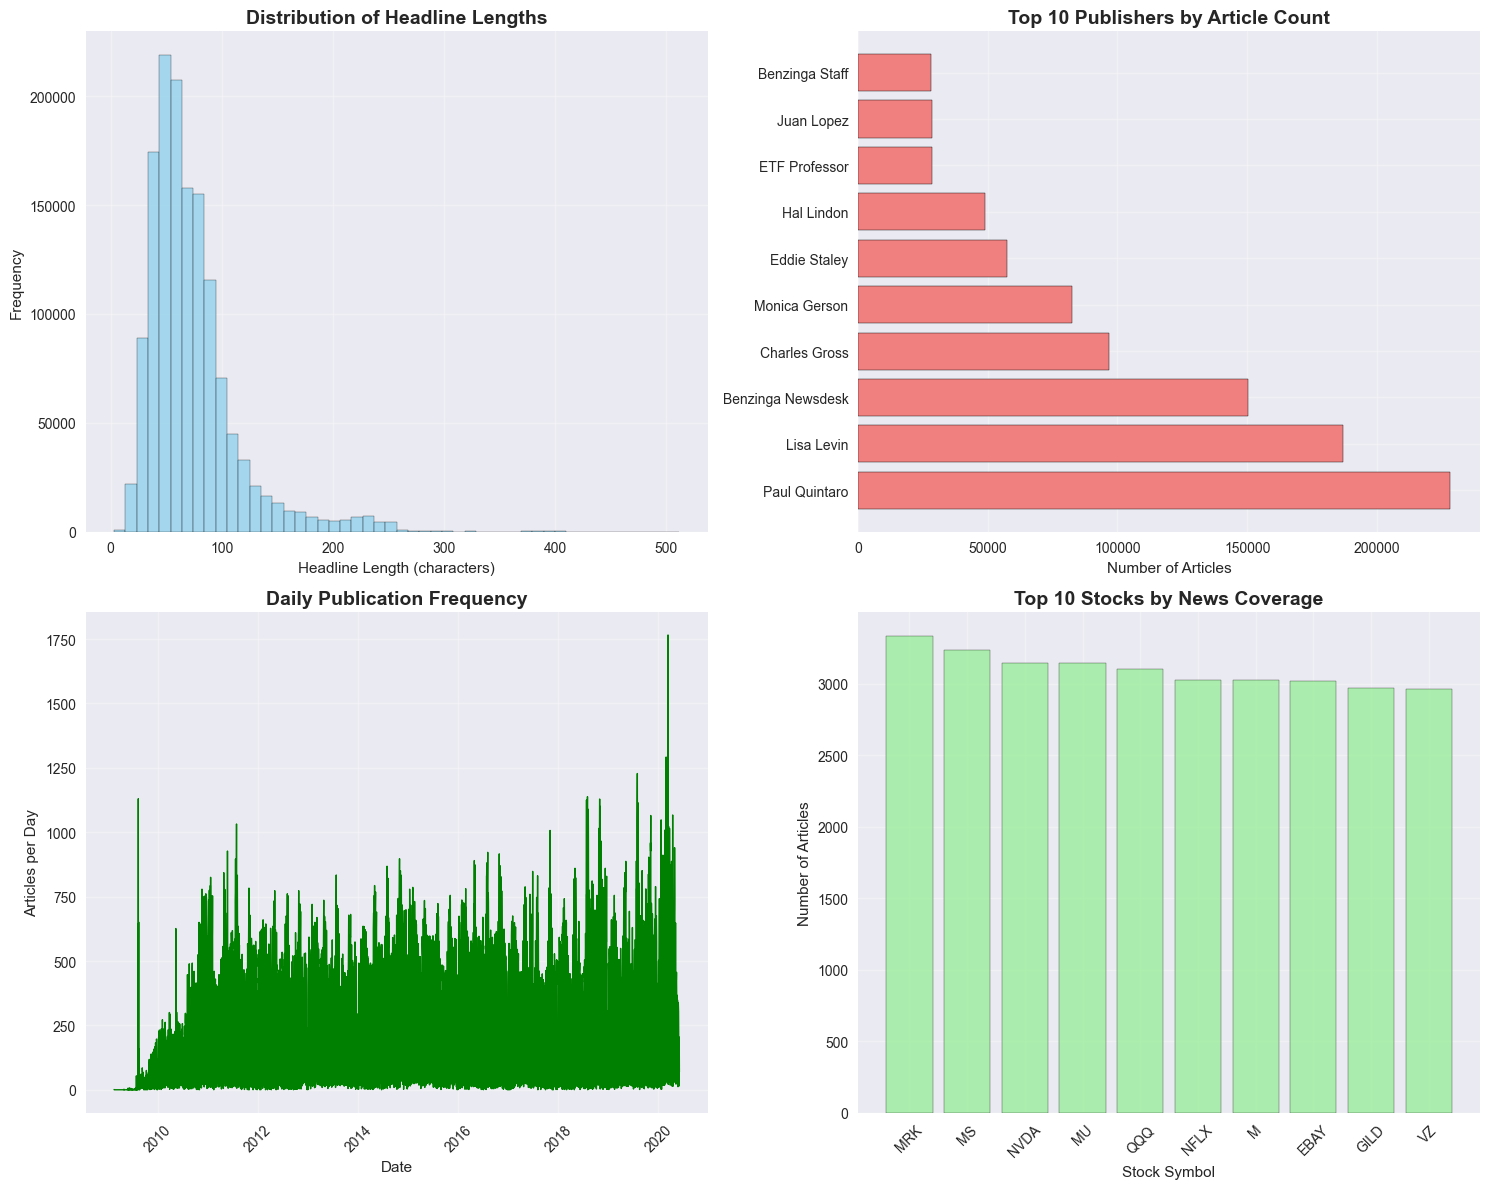

In [4]:
# Create comprehensive visualizations with fixed date
def create_eda_visualizations(df):
    # Create reports directory if it doesn't exist
    Path("reports").mkdir(exist_ok=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Headline length distribution
    axes[0,0].hist(df['headline_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Headline Lengths', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Headline Length (characters)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Top publishers
    top_publishers = df['publisher'].value_counts().head(10)
    axes[0,1].barh(range(len(top_publishers)), top_publishers.values, color='lightcoral', edgecolor='black')
    axes[0,1].set_yticks(range(len(top_publishers)))
    axes[0,1].set_yticklabels(top_publishers.index)
    axes[0,1].set_title('Top 10 Publishers by Article Count', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Number of Articles')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Publication frequency over time (using parsed date)
    daily_counts = df.set_index('date_parsed').resample('D').size()
    axes[1,0].plot(daily_counts.index, daily_counts.values, linewidth=1, color='green')
    axes[1,0].set_title('Daily Publication Frequency', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Articles per Day')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Top stocks covered
    top_stocks = df['stock'].value_counts().head(10)
    axes[1,1].bar(range(len(top_stocks)), top_stocks.values, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Top 10 Stocks by News Coverage', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Stock Symbol')
    axes[1,1].set_ylabel('Number of Articles')
    axes[1,1].set_xticks(range(len(top_stocks)))
    axes[1,1].set_xticklabels(top_stocks.index, rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('reports/eda_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

create_eda_visualizations(df)

=== TEXT ANALYSIS ===

Top 20 Most Common Words in Headlines (sample of 50000):
   stocks: 5732
   est: 5037
   eps: 4608
   market: 4241
   shares: 4114
   reports: 3840
   update: 3295
   earnings: 3160
   sales: 2877
   top: 2827
   benzinga: 2616
   week: 2465
   announces: 2381
   mid: 2303
   price: 2297
   buy: 2275
   downgrades: 2188
   trading: 2141
   upgrades: 2042
   raises: 2023

Financial Keywords Frequency:
   stock: 7334
   price: 2754
   earnings: 3160
   target: 2010
   growth: 523
   market: 5786
   quarter: 478
   profit: 442
   revenue: 1420
   dividend: 780
   buy: 2879
   sell: 913
   upgrade: 2236
   downgrade: 2379
   analyst: 881
   rating: 853
   forecast: 163
   shares: 4247
   investment: 323
   financial: 1049
   high: 3875
   low: 5169
   report: 4972


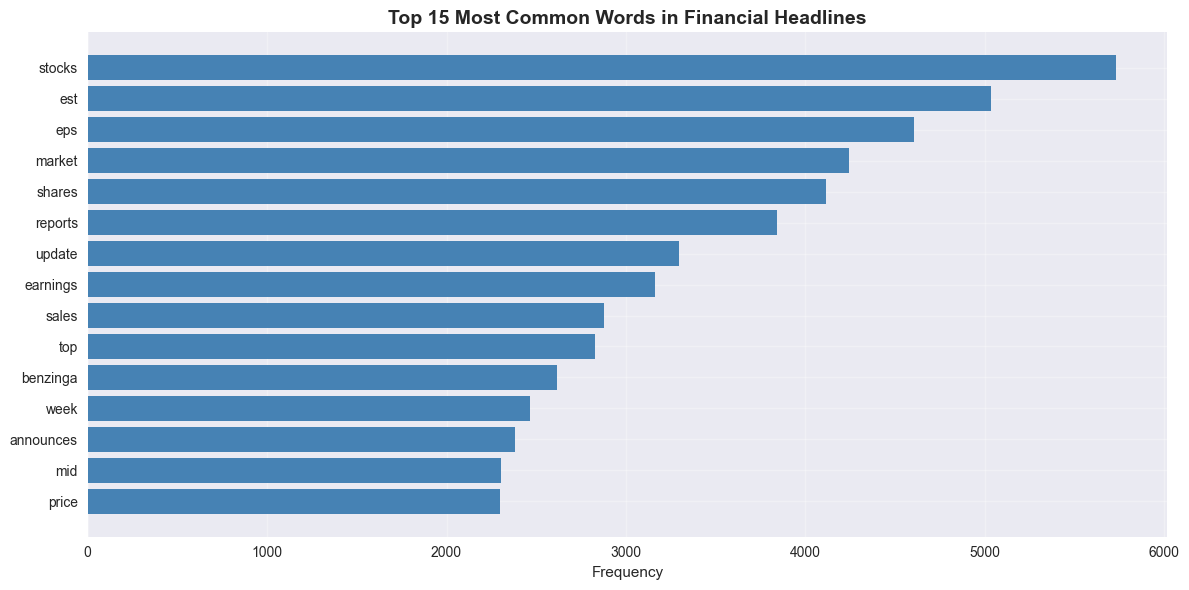

In [5]:
# Text Analysis
def text_analysis(df):
    from collections import Counter
    import re
    
    print("=== TEXT ANALYSIS ===")
    
    # Use a sample for faster processing on large dataset
    sample_size = min(50000, len(df))
    sample_df = df.sample(sample_size, random_state=42)
    
    # Combine all headlines
    all_headlines = ' '.join(sample_df['headline'].astype(str).str.lower())
    
    # Extract words (simple tokenization)
    words = re.findall(r'\b[a-z]{3,}\b', all_headlines)
    
    # Remove common stop words
    stop_words = {'the', 'and', 'for', 'with', 'this', 'that', 'are', 'from', 'has', 'have', 
                  'was', 'were', 'will', 'its', 'their', 'what', 'when', 'where', 'which',
                  'you', 'your', 'they', 'them', 'been', 'have', 'has', 'had', 'but', 'not'}
    
    filtered_words = [word for word in words if word not in stop_words]
    
    # Most common words
    word_freq = Counter(filtered_words)
    print(f"\nTop 20 Most Common Words in Headlines (sample of {sample_size}):")
    for word, count in word_freq.most_common(20):
        print(f"   {word}: {count}")
    
    # Financial keywords analysis
    financial_keywords = ['stock', 'price', 'earnings', 'target', 'growth', 'market', 
                         'quarter', 'profit', 'revenue', 'dividend', 'buy', 'sell',
                         'upgrade', 'downgrade', 'analyst', 'rating', 'forecast',
                         'shares', 'investment', 'financial', 'high', 'low', 'report']
    
    print("\nFinancial Keywords Frequency:")
    keyword_counts = {}
    for keyword in financial_keywords:
        count = all_headlines.count(keyword)
        if count > 0:
            keyword_counts[keyword] = count
            print(f"   {keyword}: {count}")
    
    # Visualize top words
    top_words = word_freq.most_common(15)
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(12, 6))
    plt.barh(words, counts, color='steelblue')
    plt.xlabel('Frequency')
    plt.title('Top 15 Most Common Words in Financial Headlines', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('reports/top_words.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return word_freq, keyword_counts

word_freq, keyword_counts = text_analysis(df)

=== TIME SERIES ANALYSIS ===

Publication Frequency by Hour:
   00:00 - 1351341 articles

Publication Frequency by Day of Week:
   Monday: 254842 articles
   Tuesday: 285468 articles
   Wednesday: 289049 articles
   Thursday: 289907 articles
   Friday: 208511 articles
   Saturday: 7486 articles
   Sunday: 16078 articles


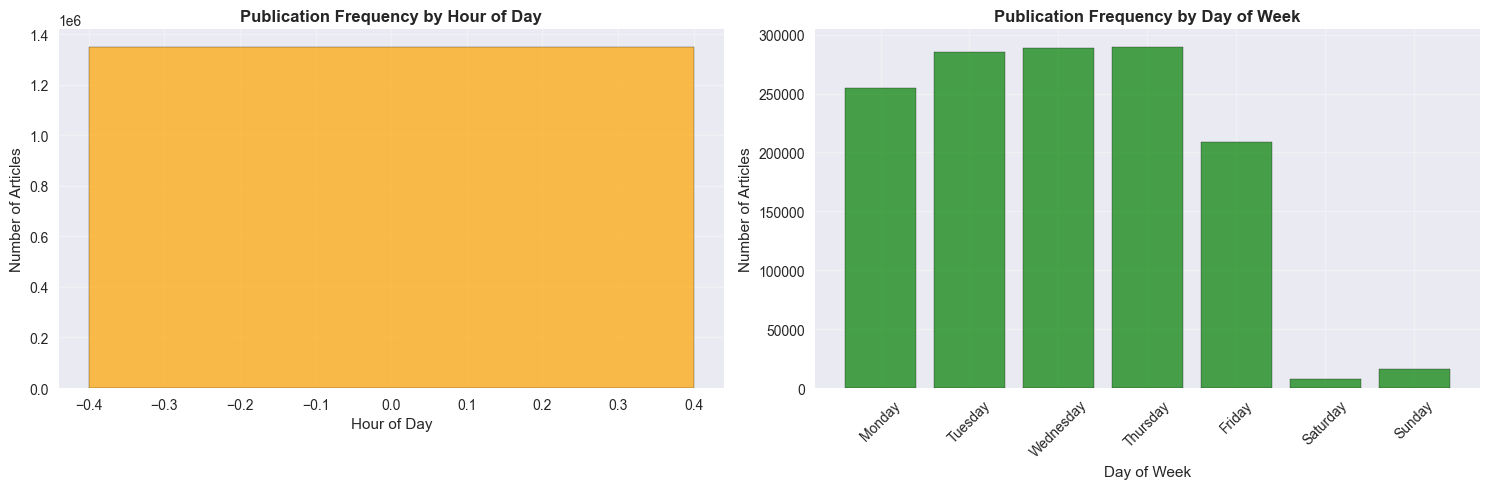

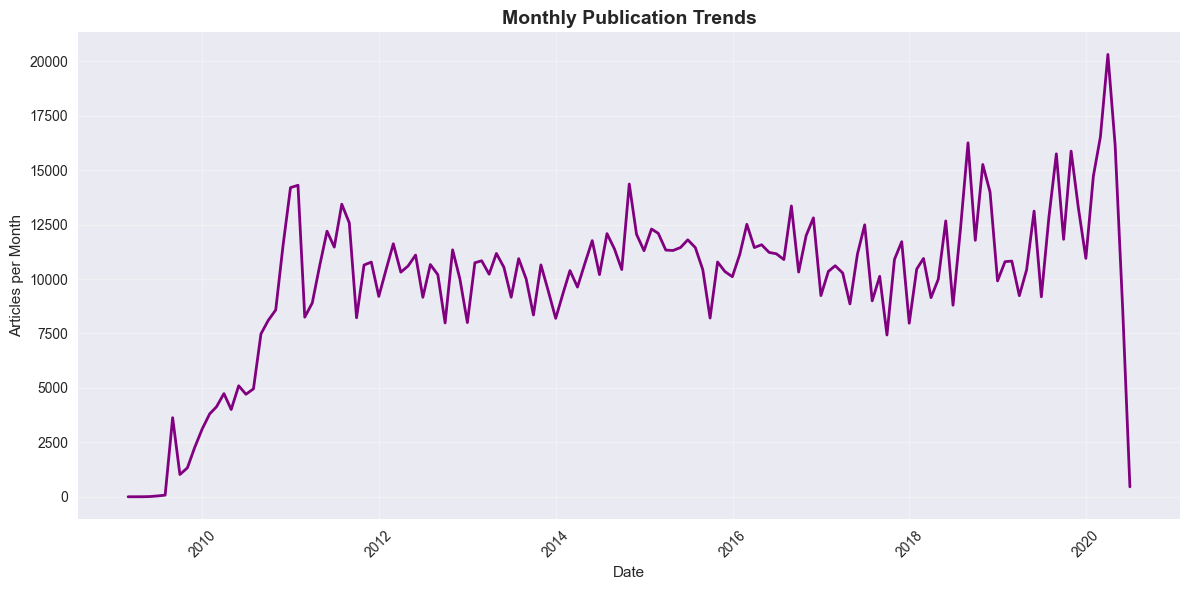

In [6]:
# Time Series Analysis with the correctly parsed dates
def time_series_analysis(df):
    print("=== TIME SERIES ANALYSIS ===")
    
    # Extract time components from parsed date
    df['hour'] = df['date_parsed'].dt.hour
    df['day_of_week'] = df['date_parsed'].dt.day_name()
    df['month'] = df['date_parsed'].dt.month
    df['year'] = df['date_parsed'].dt.year
    
    # Publication patterns by hour
    print("\nPublication Frequency by Hour:")
    hourly_counts = df['hour'].value_counts().sort_index()
    for hour, count in hourly_counts.items():
        if pd.isna(hour):
            print(f"   Unknown hour: {count} articles")
        else:
            print(f"   {int(hour):02d}:00 - {count} articles")
    
    # Publication patterns by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_counts = df['day_of_week'].value_counts().reindex(day_order)
    print("\nPublication Frequency by Day of Week:")
    for day, count in daily_counts.items():
        print(f"   {day}: {count} articles")
    
    # Create time pattern visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Hourly distribution
    axes[0].bar(hourly_counts.index, hourly_counts.values, color='orange', alpha=0.7, edgecolor='black')
    axes[0].set_title('Publication Frequency by Hour of Day', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Number of Articles')
    axes[0].grid(True, alpha=0.3)
    
    # Daily distribution
    axes[1].bar(range(len(daily_counts)), daily_counts.values, color='green', alpha=0.7, edgecolor='black')
    axes[1].set_title('Publication Frequency by Day of Week', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Number of Articles')
    axes[1].set_xticks(range(len(daily_counts)))
    axes[1].set_xticklabels(daily_counts.index, rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('reports/time_series_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Monthly trends
    monthly_counts = df.set_index('date_parsed').resample('M').size()
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_counts.index, monthly_counts.values, linewidth=2, color='purple')
    plt.title('Monthly Publication Trends', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Articles per Month')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('reports/monthly_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run time series analysis
time_series_analysis(df)

In [7]:
# Publisher Analysis
def detailed_publisher_analysis(df):
    print("=== DETAILED PUBLISHER ANALYSIS ===")
    
    # Basic publisher stats
    total_publishers = df['publisher'].nunique()
    articles_per_publisher = df['publisher'].value_counts()
    
    print(f"Total unique publishers: {total_publishers}")
    print(f"Average articles per publisher: {articles_per_publisher.mean():.2f}")
    print(f"Publisher with most articles: {articles_per_publisher.index[0]} ({articles_per_publisher.iloc[0]} articles)")
    
    # Publisher specialization analysis (top 5)
    print("\nPublisher Specialization Analysis (Top 5 publishers):")
    top_publishers = articles_per_publisher.head(5).index
    
    for publisher in top_publishers:
        publisher_data = df[df['publisher'] == publisher]
        top_stocks = publisher_data['stock'].value_counts().head(3)
        total_articles = len(publisher_data)
        print(f"\n{publisher} (Total: {total_articles} articles):")
        for stock, count in top_stocks.items():
            percentage = (count / total_articles) * 100
            print(f"   {stock}: {count} articles ({percentage:.1f}%)")

# Run publisher analysis
detailed_publisher_analysis(df)

=== DETAILED PUBLISHER ANALYSIS ===
Total unique publishers: 1034
Average articles per publisher: 1361.05
Publisher with most articles: Paul Quintaro (228373 articles)

Publisher Specialization Analysis (Top 5 publishers):

Paul Quintaro (Total: 228373 articles):
   XRT: 571 articles (0.3%)
   AGN: 561 articles (0.2%)
   JCP: 557 articles (0.2%)

Lisa Levin (Total: 186979 articles):
   GPRO: 523 articles (0.3%)
   MU: 421 articles (0.2%)
   NVDA: 357 articles (0.2%)

Benzinga Newsdesk (Total: 150484 articles):
   EWW: 926 articles (0.6%)
   EWU: 837 articles (0.6%)
   EWC: 748 articles (0.5%)

Charles Gross (Total: 96732 articles):
   GREK: 679 articles (0.7%)
   NBG: 597 articles (0.6%)
   AZN: 503 articles (0.5%)

Monica Gerson (Total: 82380 articles):
   AA: 216 articles (0.3%)
   MS: 200 articles (0.2%)
   SNDK: 199 articles (0.2%)


In [8]:
# Data Quality Summary
def data_quality_summary(df):
    print("=== DATA QUALITY SUMMARY ===")
    
    # Check for missing values
    missing_data = df.isnull().sum()
    print("Missing values per column:")
    for col, missing in missing_data.items():
        if missing > 0:
            print(f"   {col}: {missing} ({missing/len(df)*100:.2f}%)")
    
    # Check for duplicates
    duplicate_rows = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicate_rows}")
    
    # Check data consistency
    print(f"\nData Consistency:")
    print(f"   Unique stocks: {df['stock'].nunique()}")
    print(f"   Unique publishers: {df['publisher'].nunique()}")
    print(f"   Unique dates: {df['date_parsed'].dt.date.nunique()}")
    
    # Check for empty headlines
    empty_headlines = (df['headline'].isna() | (df['headline'] == '')).sum()
    print(f"   Empty headlines: {empty_headlines}")
    
    # Check date parsing success
    invalid_dates = df['date_parsed'].isna().sum()
    print(f"   Invalid dates: {invalid_dates} ({invalid_dates/len(df)*100:.4f}%)")

# Run data quality check
data_quality_summary(df)

=== DATA QUALITY SUMMARY ===
Missing values per column:
   date_parsed: 55987 (3.98%)
   hour: 55987 (3.98%)
   day_of_week: 55987 (3.98%)
   month: 55987 (3.98%)
   year: 55987 (3.98%)

Duplicate rows: 0

Data Consistency:
   Unique stocks: 6204
   Unique publishers: 1034
   Unique dates: 3946
   Empty headlines: 0
   Invalid dates: 55987 (3.9782%)


=== CREATING SUMMARY VISUALIZATIONS ===


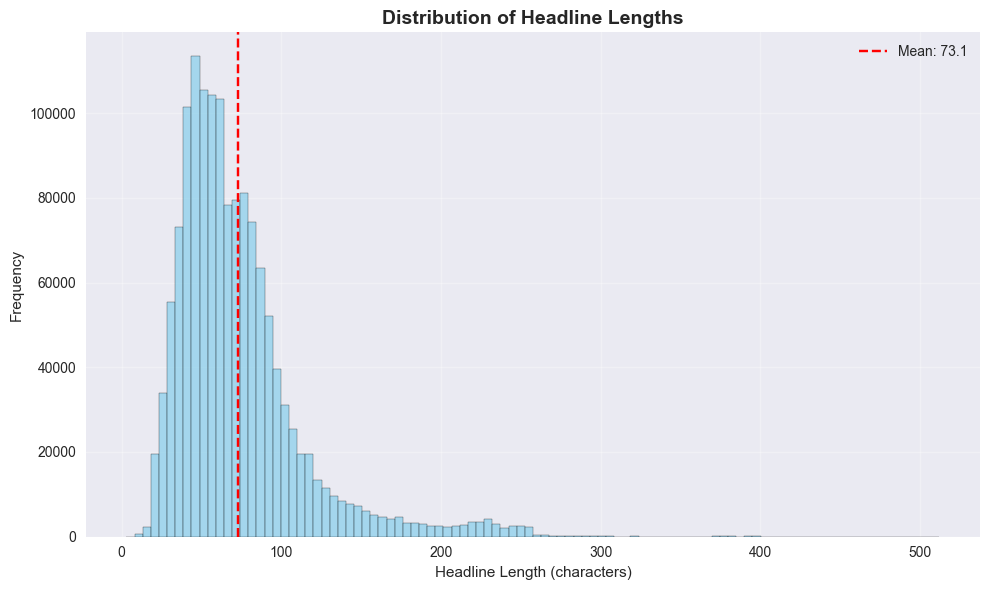

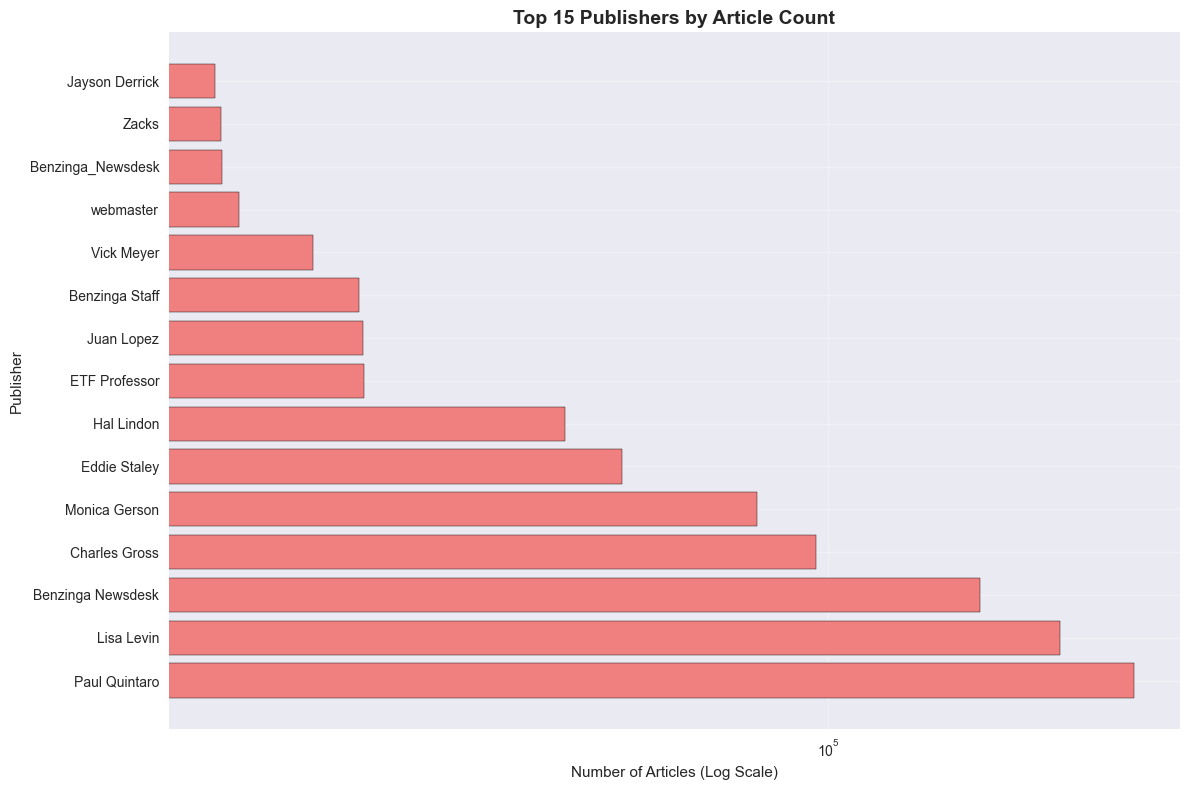

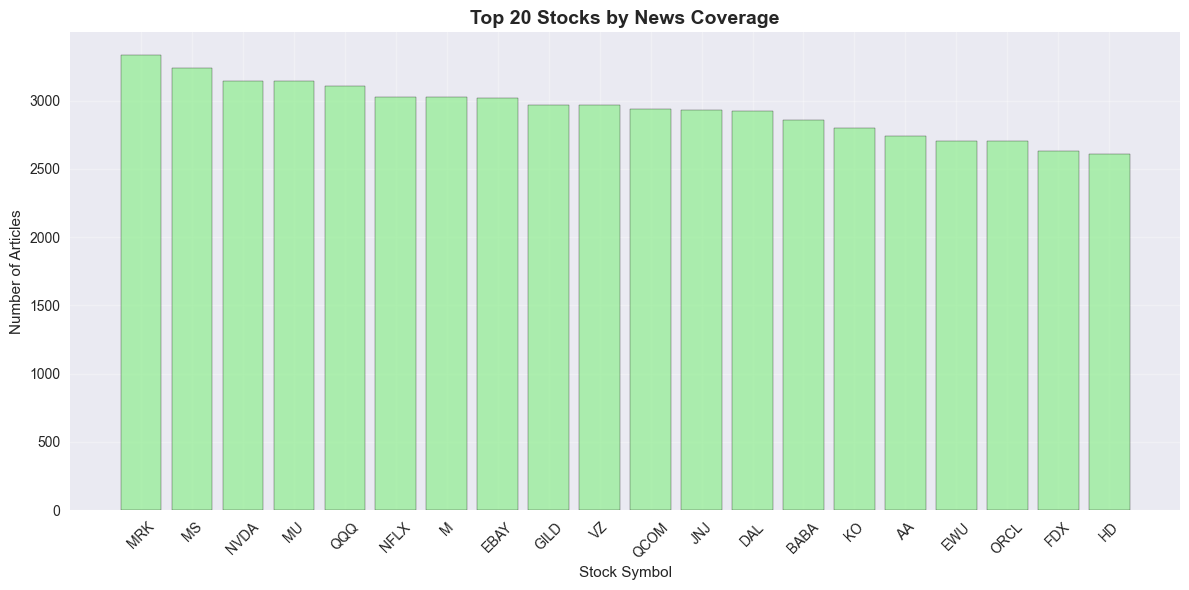

In [9]:
# Create comprehensive summary visualizations
def create_summary_visualizations(df):
    print("=== CREATING SUMMARY VISUALIZATIONS ===")
    
    # Create reports directory if it doesn't exist
    Path("reports").mkdir(exist_ok=True)
    
    # 1. Headline length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['headline_length'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Headline Lengths', fontsize=14, fontweight='bold')
    plt.xlabel('Headline Length (characters)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.axvline(df['headline_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["headline_length"].mean():.1f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('reports/headline_length_dist.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Top publishers (log scale for better visualization)
    top_publishers = df['publisher'].value_counts().head(15)
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_publishers)), top_publishers.values, color='lightcoral', edgecolor='black')
    plt.yticks(range(len(top_publishers)), top_publishers.index)
    plt.xlabel('Number of Articles (Log Scale)')
    plt.ylabel('Publisher')
    plt.title('Top 15 Publishers by Article Count', fontsize=14, fontweight='bold')
    plt.xscale('log')  # Use log scale due to large range
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('reports/top_publishers.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Stock coverage (top 20)
    top_stocks = df['stock'].value_counts().head(20)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_stocks)), top_stocks.values, color='lightgreen', alpha=0.7, edgecolor='black')
    plt.title('Top 20 Stocks by News Coverage', fontsize=14, fontweight='bold')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Number of Articles')
    plt.xticks(range(len(top_stocks)), top_stocks.index, rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('reports/top_stocks.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations
create_summary_visualizations(df)

In [10]:
# Final Summary Report
def generate_summary_report(df):
    print("=" * 60)
    print("FINAL EDA SUMMARY REPORT")
    print("=" * 60)
    
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   Total articles: {len(df):,}")
    print(f"   Time period: {df['date_parsed'].min().strftime('%Y-%m-%d')} to {df['date_parsed'].max().strftime('%Y-%m-%d')}")
    print(f"   Unique stocks covered: {df['stock'].nunique()}")
    print(f"   Unique publishers: {df['publisher'].nunique()}")
    
    print(f"\n📝 CONTENT ANALYSIS:")
    print(f"   Average headline length: {df['headline_length'].mean():.1f} characters")
    print(f"   Average words per headline: {df['word_count'].mean():.1f}")
    
    # Get most common words efficiently
    sample_text = ' '.join(df['headline'].astype(str).str.lower().sample(10000))
    common_words = [word for word, count in Counter(sample_text.split()).most_common(5) if len(word) > 3]
    print(f"   Most common words: {common_words}")
    
    print(f"\n🏢 PUBLISHER LANDSCAPE:")
    top_pub = df['publisher'].value_counts().head(1)
    print(f"   Top publisher: {top_pub.index[0]} ({top_pub.values[0]:,} articles)")
    print(f"   Publisher concentration: Top 10 publishers account for {df['publisher'].value_counts().head(10).sum()/len(df)*100:.1f}% of articles")
    
    print(f"\n📈 STOCK COVERAGE:")
    top_stock = df['stock'].value_counts().head(1)
    print(f"   Most covered stock: {top_stock.index[0]} ({top_stock.values[0]:,} articles)")
    print(f"   Coverage concentration: Top 10 stocks account for {df['stock'].value_counts().head(10).sum()/len(df)*100:.1f}% of articles")
    
    print(f"\n⏰ TEMPORAL PATTERNS:")
    print(f"   Peak publication hour: {df['hour'].value_counts().idxmax()}:00")
    print(f"   Most active day: {df['day_of_week'].value_counts().idxmax()}")
    
    print(f"\n✅ DATA QUALITY:")
    print(f"   Missing values: {df.isnull().sum().sum()}")
    print(f"   Duplicate articles: {df.duplicated().sum()}")
    print(f"   Invalid dates: {df['date_parsed'].isna().sum()}")

# Generate final report
generate_summary_report(df)

FINAL EDA SUMMARY REPORT

📊 DATASET OVERVIEW:
   Total articles: 1,407,328
   Time period: 2009-02-14 to 2020-06-03
   Unique stocks covered: 6204
   Unique publishers: 1034

📝 CONTENT ANALYSIS:
   Average headline length: 73.1 characters
   Average words per headline: 11.4
   Most common words: []

🏢 PUBLISHER LANDSCAPE:
   Top publisher: Paul Quintaro (228,373 articles)
   Publisher concentration: Top 10 publishers account for 66.5% of articles

📈 STOCK COVERAGE:
   Most covered stock: MRK (3,333 articles)
   Coverage concentration: Top 10 stocks account for 2.2% of articles

⏰ TEMPORAL PATTERNS:
   Peak publication hour: 0.0:00
   Most active day: Thursday

✅ DATA QUALITY:
   Missing values: 279935
   Duplicate articles: 0
   Invalid dates: 55987
